In [1]:
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.11.0
0.11.0
cpu


In [3]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

In [9]:
tacotron2

Tacotron2(
  (embedding): Embedding(38, 512)
  (encoder): _Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): _Decoder(
    (prenet): _Prenet(
      (layers): ModuleList(
        (0): Linear(in_features=80, out_features=256, bias=False)
        (1): Linear(in_features=256, out_features=256, bias=False)
      )
    )
    

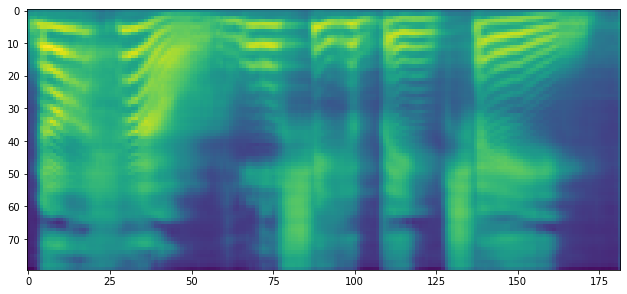

In [10]:
text = "ni hao, wo shi hu bing cheng"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)


plt.imshow(spec[0].cpu().detach())

Using cache found in /home/bh2283/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


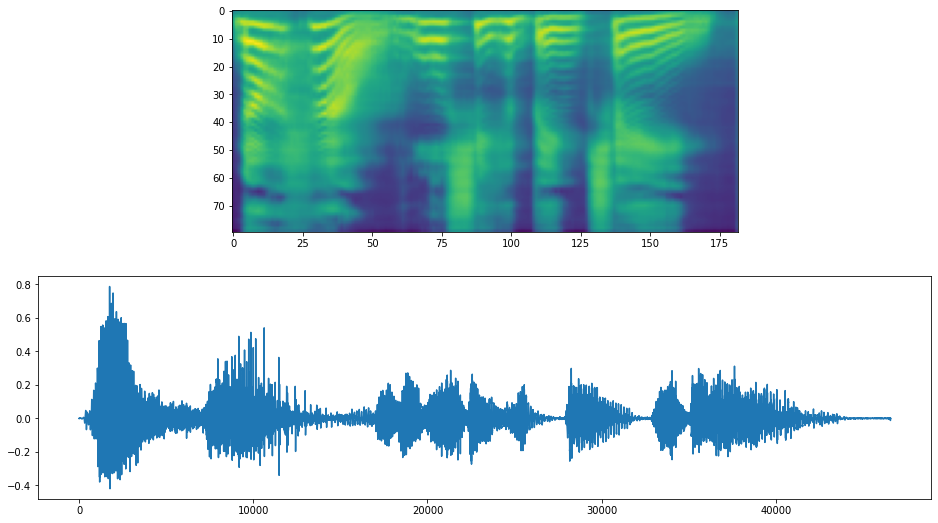

In [11]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained=False,
)
checkpoint = torch.hub.load_state_dict_from_url(
    "https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth",  # noqa: E501
    progress=False,
    map_location=device,
)
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to(device)
waveglow.eval()

with torch.no_grad():
    waveforms = waveglow.infer(spec)

fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9))
ax1.imshow(spec[0].cpu().detach())
ax2.plot(waveforms[0].cpu().detach())

torchaudio.save("_assets/my_output_waveglow.wav", waveforms[0:1].cpu(), sample_rate=22050)